In [1]:
####### importing all required packages here ##########
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from qiskit import *
from qiskit import BasicAer
from qiskit.aqua.algorithms import QAOA, NumPyMinimumEigensolver, VQE
from qiskit.optimization.algorithms import MinimumEigenOptimizer, GroverOptimizer
from qiskit.optimization import QuadraticProgram
from qiskit.aqua import QuantumInstance

In [2]:
from qiskit import IBMQ
provider = IBMQ.load_account()
#backend = provider.get_backend('ibmq_qasm_simulator')
backend = Aer.get_backend('qasm_simulator')

C:\Users\chitr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [3]:
############# Creating edge matrix #############

def create_edge_matrix(number_of_points, probability):
    edge_matrix = np.ones((number_of_points,number_of_points))
    for i in range(0,number_of_points):
        for j in range(i,number_of_points):
            if random.random()>probability or i==j:
                edge_matrix[i,j]=0
                edge_matrix[j,i]=0
    return edge_matrix

#create_edge_matrix(5, 0.5)

In [4]:
############ Creating and exporting Quadratic program ############

def Create_quadratic_program(n, edge_matrix):
    qubo = QuadraticProgram()
    linear_coefficients = list()
    summation_terms = dict()
    for i in range(n):
        qubo.binary_var('x'+ str(i))
        linear_coefficients.append(1)
    for i in range(n-1):
        for j in range(i+1,n):
            if edge_matrix[i,j] == 1:
                summation_terms[('x'+str(i),'x'+str(j))] = summation_terms.get(('x'+str(i),'x'+str(j)), -4*n)
    qubo.maximize(linear= linear_coefficients, quadratic= summation_terms)
    #print(qubo.export_as_lp_string())
    #op, offset = qubo.to_ising()
    return qubo
#Create_quadratic_program(5, create_edge_matrix(5,0.5))

In [5]:
######### Solving using NumpyeigenSolver ############

def result_exact(qubo):
    exact_mes = NumPyMinimumEigensolver()
    exact = MinimumEigenOptimizer(exact_mes)
    exact_result = exact.solve(qubo)
    return exact_result.fval
#qubo = Create_quadratic_program(17, create_edge_matrix(17,0.5))
#result_exact(qubo)

############ working fine till 16 only ##############

In [6]:
######### Solving using QAOA ########

def result_qaoa(qubo):
    qaoa_mes = QAOA(quantum_instance=backend)
    qaoa = MinimumEigenOptimizer(qaoa_mes)
    qaoa_result = qaoa.solve(qubo)
    return qaoa_result.fval
#qubo = Create_quadratic_program(4, create_edge_matrix(4,0.5))
#result_qaoa(qubo)

In [7]:
####### decimal to binary converter #######

def dec_to_bin(decimal, no_bits):
    binary = np.zeros((no_bits))
    for i in range(no_bits-1,-1,-1):
        #print(decimal, i)
        if int(decimal/(2**i)):
            binary[i]=1
        decimal = decimal%(2**i)
    return binary[::-1]
#dec_to_bin(5,4)

In [8]:
######## solving using Brute force ###########

def brute_force(n, edge_matrix):
    best_cost = 0
    best_case =None
    flag = True
    for i in range(2**n):
        binary = dec_to_bin(i,n)
        ans = sum(binary)
        for j in range(n-1):
            for k in range(j+1,n):
                if edge_matrix[j,k]==1:
                    ans = ans - 4*n*binary[j]*binary[k]
        if ans>best_cost:
            best_cost = ans
            #best_case = binary
    return best_cost
#brut_force(8, create_edge_matrix(8,0.5))

In [9]:
########### solving using VQE #########

def using_vqe(qubo):
    vqe = VQE(quantum_instance=backend)
    vqe_optimizer = MinimumEigenOptimizer(vqe)
    result = vqe_optimizer.solve(qubo)
    return result.fval
qubo = Create_quadratic_program(14, create_edge_matrix(14,0.5))
#using_vqe(qubo)

In [10]:
######## solving Using Grover ##########

def using_grover(n,qubo):
    backend = BasicAer.get_backend('qasm_simulator')
    grover_optimizer = GroverOptimizer(n, num_iterations=10, quantum_instance= backend)
    results = grover_optimizer.solve(qubo)
    return results
#qubo = Create_quadratic_program(5, create_edge_matrix(5,0.5))
#using_grover(5,qubo)

In [11]:
def main_function(n1,n2):
    cost_vs_n = list()
    time_vs_n = list()
    ratio_vs_n = list()
    cost_brute = list()
    cost_numpy = list()
    cost_qaoa = list()
    cost_vqe = list()
    time_brute = list()
    time_numpy = list()
    ratio_qaoa = list()
    ratio_vqe = list()
    print( "n & brute_force & Numpysolver & QAOA & VQE")
    for i in range(n1,n2):
        for j in range(5):
            adj_matrix = create_edge_matrix(i,0.5)
            qubo = Create_quadratic_program(i, adj_matrix)

            initial_time = time.time()
            cost_brute.append(brute_force(i,adj_matrix))
            final_time = time.time()
            time_brute.append(final_time - initial_time)

            initial_time = time.time()
            cost_numpy.append(result_exact(qubo))
            final_time = time.time()
            time_numpy.append(final_time - initial_time)

            
            cost_qaoa.append(result_qaoa(qubo))

            cost_vqe.append(using_vqe(qubo))

            ratio_qaoa.append(cost_qaoa[j]/cost_brute[j])
            ratio_vqe.append(cost_vqe[j]/cost_brute[j])

        (n, cb, cn, cq, cv) = (i, sum(cost_brute)/5.0, sum(cost_numpy)/5.0, sum(cost_qaoa)/5.0, sum(cost_vqe)/5.0)
        (n, tb, tn) = (i, sum(time_brute)/5.0, sum(time_numpy)/5.0)
        (n, rq, rv) = (i, sum(ratio_qaoa)/5.0, sum(ratio_vqe)/5.0)

        print(n,'&', cb, '&', tb, '&', cn, '&', tn, '&', cq, '&', '&', cv, '&', rq, rv)    

        cost_vs_n.append((n, cb, cn, cq, cv))
        time_vs_n.append((n, tb, tn))
        ratio_vs_n.append((n, rq, rv))

        cost_brute.clear()
        cost_numpy.clear()
        cost_qaoa.clear()
        cost_vqe.clear()
        time_brute.clear()
        time_numpy.clear()
        ratio_qaoa.clear()
        ratio_vqe.clear()

    return cost_vs_n, time_vs_n, ratio_vs_n

In [12]:
cost_vs_n, time_vs_n = main_function(4, 15)

n & brute_force & Numpysolver & QAOA & VQE
4 & 1.8 & 0.00039930343627929686 & 1.8 & 0.03530397415161133 & 1.8 & & 1.8 & 1.0 1.0
C:\Users\chitr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
5 & 2.8 & 0.0009971141815185546 & 2.8 & 0.03430805206298828 & 2.8 & & 2.8 & 1.0 1.0
6 & 2.6 & 0.0024003982543945312 & 2.6 & 0.04409289360046387 & 2.6 & & 2.6 & 1.0 1.0
7 & 3.2 & 0.005577945709228515 & 3.2 & 0.05744538307189941 & 3.2 & & 2.8 & 1.0 0.8833333333333332
8 & 3.4 & 0.011973381042480469 & 3.4 & 0.08058562278747558 & 3.4 & & 3.2 & 1.0 0.95
9 & 3.2 & 0.02872328758239746 & 3.2 & 0.12646889686584473 & 3.0 & & 3.0 & 0.95 0.9333333333333333
10 & 3.8 & 0.07996554374694824 & 3.8 & 0.07341461181640625 & 3.6 & & 3.6 & 0.95 0.95
11 & 3.8 & 0.170933

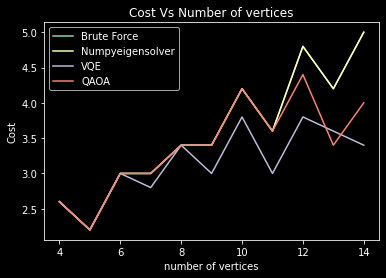

In [13]:
#### plotting cost vs n #####
plt.title("Cost Vs Number of vertices")
plt.ylabel('Cost')
plt.xlabel('number of vertices')
n, cb, cn, cq, cv = zip(*cost_vs_n)
plt.plot(n, cb, label = 'Brute Force')
plt.plot(n, cn, label = 'Numpyeigensolver')
plt.plot(n, cv, label = 'VQE')
plt.plot(n, cq, label = 'QAOA')
plt.legend()


In [17]:
ratio_vs_n = list([ (4, 1.0 ,1.0), (5, 1.0, 1.0), (6, 1.0, 1.0), (7, 1.0, 0.883333), (8, 1.0, 0.95), (9, 0.95, 0.933333), (10, 0.95, 0.95),(11, 1.0, 0.869999), (12, 1.0, 0.833333), (13, 0.86, 0.84), (14, 0.869999, 0.78) ])

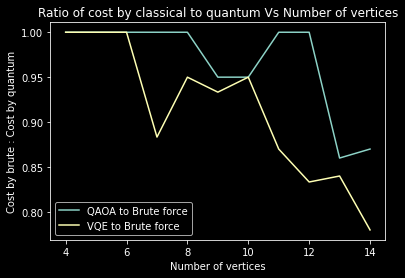

In [18]:
ratio = list()
for i in range(4,15):
    ratio.append((i, cost_vs_n[i-4][3]/cost_vs_n[i-4][1], cost_vs_n[i-4][4]/cost_vs_n[i-4][1]))
plt.title("Ratio of cost by classical to quantum Vs Number of vertices")
plt.ylabel("Cost by brute : Cost by quantum")
plt.xlabel("Number of vertices")
n, rq, rv = zip(*ratio_vs_n)
plt.plot(n, rq, label = 'QAOA to Brute force')
plt.plot(n, rv, label = 'VQE to Brute force')
plt.legend()

In [9]:
time_vs_n = list([(4, 0.0006585121154785156, 0.048387765884399414),
 (5, 0.001963186264038086, 0.04445958137512207),
 (6, 0.002765369415283203, 0.04832468032836914),
 (7, 0.004782867431640625, 0.04429912567138672),
 (8, 0.013977384567260743, 0.08099851608276368),
 (9, 0.027930688858032227, 0.09194908142089844),
 (10, 0.0629500389099121, 0.048883914947509766),
 (11, 0.10027985572814942, 0.03946566581726074),
 (12, 1.1908369541168213, 0.26498703956604003),
 (13, 1.6870797634124757, 0.3020028114318848),
 (14, 1.2807737350463868, 0.10729289054870605)])

In [10]:
time_vs_n_qaoa = list([ (14, 0.111), (13, 0.067), (12, 0.039), (11, 0.043), (10, 0.042), (9, 0.04), (8, 0.031), (7, 0.028), (6, 0.025), (5, 0.021), (4, 0.027)])

In [59]:
####### appended time for each n manually
#time_vs_n_qaoa.append((4, 0.027))

In [11]:
print(time_vs_n_qaoa)

[(14, 0.111), (13, 0.067), (12, 0.039), (11, 0.043), (10, 0.042), (9, 0.04), (8, 0.031), (7, 0.028), (6, 0.025), (5, 0.021), (4, 0.027)]


In [38]:
time_vs_n_vqe = list([(4, 0.098),
 (5, 0.114),
 (6, 0.138),
 (7, 0.182),
 (8, 0.223),
 (9, 0.276),
 (10, 0.356),
 (11, 0.462),
 (12, 0.571),
 (13, 0.787),
 (14, 1.367)]) 

In [ ]:
##time_vs_n_vqe.append((14, 1.367))

In [39]:
time_vs_n_vqe

[(4, 0.098),
 (5, 0.114),
 (6, 0.138),
 (7, 0.182),
 (8, 0.223),
 (9, 0.276),
 (10, 0.356),
 (11, 0.462),
 (12, 0.571),
 (13, 0.787),
 (14, 1.367)]

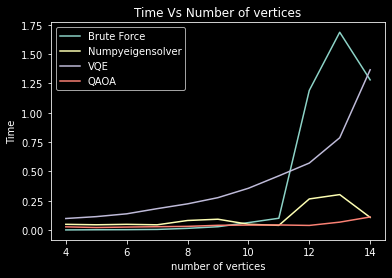

In [40]:
######### Plotting Time Vs n ########
plt.title("Time Vs Number of vertices")
plt.ylabel('Time')
plt.xlabel('number of vertices')
n, tb, tn = zip(*time_vs_n)
plt.plot(n, tb, label = 'Brute Force')
plt.plot(n, tn, label = 'Numpyeigensolver')
n, tv = zip(*time_vs_n_vqe)
plt.plot(n, tv, label = 'VQE')
n, tq = zip(*time_vs_n_qaoa)
plt.plot(n, tq, label = 'QAOA')
plt.legend()

In [41]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.15.1',
 'qiskit-aer': '0.6.1',
 'qiskit-ignis': '0.4.0',
 'qiskit-ibmq-provider': '0.8.0',
 'qiskit-aqua': '0.7.5',
 'qiskit': '0.20.0'}

In [42]:
from platform import python_version
python_version()

'3.8.6'

In [ ]:
## Code by Chitresh Bhaskar Chaudhari 
## github.com/chit38